# Compute Frechet Inception Distance for a model

To do this, one needs an "Inception Net". A discriminator that discriminates between real and fake samples.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn

In [22]:
from random import shuffle

In [2]:
import pdb

In [3]:
import h5py
import gc
import joblib
from glob import glob

In [4]:
from utils.utils import load_netE, load_netG, segment_image, load_InceptionNet
from hmm.hmm_utils import generate_samples

In [27]:
from models.nets_16col_residual import _netG, InceptionNet, FID

In [6]:
from data.dataset import bird_dataset_single_hdf

In [21]:
from torch.utils.data import TensorDataset, DataLoader

# load a bird, get its songs from some day

In [7]:
dataset = bird_dataset_single_hdf('/home/songbird/datapartition/all_birds.hdf', 'r15y5')

... total number of folders for bird r15y5 = 41 ...


In [8]:
# choose a day
X = dataset.get(day=18, nsamps=-1)

In [16]:
X[0].shape

(129, 133)

# load a generator

In [10]:
netG = load_netG('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz12_alldaysnets/netG_epoch_60_day_all.pth',
                 nz=12, ngf=128, cuda=True, resnet=True)

# load hmm

In [11]:
# load hmm
hmm = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz12_alldaysnets/day_18/hmm_hiddensize_100/model_day_18.pkl')
hmm = hmm['model']

In [12]:
timesteps_per_sample = [x.shape[1]//16 for x in X]

In [ ]:
sample_seqs = generate_samples(netG, hmm, nsamples=len(X), invtemp=1., timesteps=timesteps_per_sample, cuda=True)

In [ ]:
len(sample_seqs)

In [ ]:
sample_seqs[0].shape

# load a trained Inception Net

In [18]:
netI = load_InceptionNet('/home/songbird/datapartition/mdgan_output/daily_gan/r15s12_nz12_alldaysnets/netD3_epoch_60_day_all.pth', 
                ndf = 128, cuda=True, resnet=True)

# train a new Inception Net

In [155]:
# make a dataset

real = []
fake = []
for x,s in zip(X, sample_seqs):
    
    real.append(np.stack(segment_image(x, width = 16)))
    fake.append(np.stack(segment_image(s, width = 16)))

real = np.concatenate(real)
fake = np.concatenate(fake)

x = np.concatenate([real, fake], axis=0)

print(x.shape)

x = torch.from_numpy(x).view(-1, real.shape[1], real.shape[2]).to(torch.float32).cuda()


(123114, 129, 16)


In [157]:
y = np.concatenate([np.ones((real.shape[0], 1)), np.zeros((fake.shape[0],1))])
y = torch.from_numpy(y).to(torch.float32).cuda()

In [134]:
x = None
y = None
gc.collect()
torch.cuda.empty_cache()

In [158]:
#y = torch.from_numpy(y).to(torch.long).cuda()
#y = y.to(torch.long).cuda()
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [159]:
len(dataloader)

3848

In [167]:
model = None
gc.collect()
torch.cuda.empty_cache()

In [103]:
nepochs = 5
lr = 3e-5
l2 = 1e-4
log_every = 500

In [104]:
model = InceptionNet(ndf=8, nc=1, lr = lr, l2=l2, log_every=log_every)
model = model.cuda()

In [153]:
model = InceptionNetRecurrent(indims=129, nrnn=100, nrnnlayers=1, nembed=12, 
                                 lr=1e-4, l2=1e-4, log_every=100)
model = model.cuda()

In [160]:
for n in range(nepochs):
    model.fit(dataloader)

..... batch=200/3848 loss = 0.001 .....
..... batch=300/3848 loss = 0.000 .....
..... batch=400/3848 loss = 0.000 .....
..... batch=500/3848 loss = 0.000 .....
..... batch=600/3848 loss = 0.000 .....
..... batch=700/3848 loss = 0.000 .....
..... batch=800/3848 loss = 0.000 .....
..... batch=900/3848 loss = 0.000 .....
..... batch=1000/3848 loss = 0.002 .....
..... batch=1100/3848 loss = 0.000 .....
..... batch=1200/3848 loss = 0.000 .....
..... batch=1300/3848 loss = 0.000 .....
..... batch=1400/3848 loss = 0.000 .....
..... batch=1500/3848 loss = 0.000 .....
..... batch=1600/3848 loss = 0.001 .....
..... batch=1700/3848 loss = 0.000 .....
..... batch=1800/3848 loss = 0.001 .....
..... batch=1900/3848 loss = 0.017 .....
..... batch=2000/3848 loss = 0.000 .....
..... batch=2100/3848 loss = 0.000 .....
..... batch=2200/3848 loss = 0.000 .....
..... batch=2300/3848 loss = 0.001 .....
..... batch=2400/3848 loss = 0.000 .....
..... batch=2500/3848 loss = 0.000 .....
..... batch=2600/3848 lo

In [89]:
dataset = None
dataloader = None
gc.collect()

17

In [130]:
len(X) // 400

7

# get FID scores

In [131]:

FID_scores = []

N = 0
minsamps = 800
x_real = []
x_fake = []

with torch.no_grad():
    
    for n in range(len(X)):
         
        x_r = np.stack(segment_image(X[n], width = 16))
        x_f = np.stack(segment_image(sample_seqs[n], width = 16))

        
        if len(x_real) < minsamps:
            
            if len(x_real)==0:
                x_real = x_r * 1.
                x_fake = x_f * 1.
            else:
                x_real = np.concatenate([x_real, x_r])
                x_fake = np.concatenate([x_fake, x_f])
                
            continue
            
        x_r = torch.from_numpy(x_real).view(-1, 1, x_real.shape[1], x_real.shape[2]).to(torch.float32).cuda()
        x_f = torch.from_numpy(x_fake).view(-1, 1, x_fake.shape[1], x_fake.shape[2]).to(torch.float32).cuda()
        
        x_real, x_fake = [], []
        
        score = model.fid_score(x_r, x_f)

        FID_scores.append(score)

        if n % 10 == 0:
            print('..... done with %.3f percent .....'%(n*100 / len(X)))
            print(f'..... FID: {score} .....')

..... done with 6.538 percent .....
..... FID: 171.75294126320696 .....
..... done with 25.809 percent .....
..... FID: 170.89524257133695 .....
..... done with 42.326 percent .....
..... FID: 172.86820605063426 .....
..... done with 55.747 percent .....
..... FID: 174.6679658202172 .....
..... done with 62.629 percent .....
..... FID: 168.94993283932493 .....
..... done with 65.382 percent .....
..... FID: 171.80010611306625 .....
..... done with 72.608 percent .....
..... FID: 172.4665467598073 .....
..... done with 94.976 percent .....
..... FID: 173.71792651971512 .....


In [136]:
hmm.n_features

12

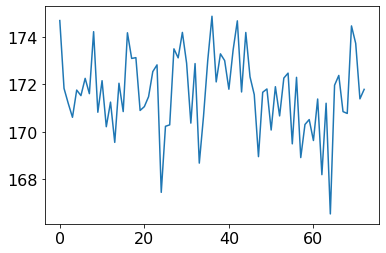

In [137]:
plt.plot(FID_scores)

# FID score for full sequences

In [165]:
FID_scores = []

N = 0
minsamps = 32
x_real = np.array([])
x_fake = np.array([])

with torch.no_grad():
    
    for n in range(len(X)):
         
        x_r = np.expand_dims(X[n], axis=0)
        x_f = np.expand_dims(sample_seqs[n],axis=0)

        
        if len(x_real) < minsamps:
            
            if len(x_real)==0:
                x_real = x_r
                x_fake = x_f
                
            else:
                x_real = np.concatenate([x_real, x_r], axis=0)
                x_fake = np.concatenate([x_fake, x_f], axis=0)
                
            continue
            
        pdb.set_trace()
        x_r = torch.from_numpy(x_real).to(torch.float32).cuda()
        x_f = torch.from_numpy(x_fake).to(torch.float32).cuda()
        
        x_real, x_fake = np.array([]), np.array([])
        
        score = model.fid_score(x_r, x_f)

        FID_scores.append(score)

        if n % 10 == 0:
            print('..... done with %.3f percent .....'%(n*100 / len(X)))
            print(f'..... FID: {score} .....')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 133 and the array at index 1 has size 148

In [152]:
class InceptionNetRecurrent(nn.Module):
    """A discriminator network from which fid_score can be computed
        Inputs are assumed to be full spectrograms.
    """
    def __init__(self, indims=129, nrnn=100, nrnnlayers=1, nembed=12, nlin=50, leak=0.1,
                 dropout=0.0, lr=1e-4, l2=1e-4, bidirectional=False, log_every=100):
        super(InceptionNetRecurrent, self).__init__()
        
        self.encoder_rnn = nn.GRU(indims, nrnn, nrnnlayers, bidirectional=False,
                          dropout=dropout, batch_first=True)
        self.decoder_rnn = nn.GRU(nembed, nrnn, nrnnlayers, bidirectional=False,
                          dropout=dropout, batch_first=True)
        
        bid = 2 if bidirectional else 1
        
        self.mlp_in = nn.Sequential(
            nn.Linear(nrnn*bid, nlin),
            nn.LayerNorm(nlin),
            nn.LeakyReLU(leak),
            
            nn.Linear(nlin, nlin),
            nn.LayerNorm(nlin),
            nn.LeakyReLU(leak),
            
            nn.Linear(nlin, nembed)
        )
        
        self.classifier = nn.Linear(nembed, 1)
        
        self.len_in = None
        
        self.out_act =nn.Sigmoid()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2, betas = (0.5, 0.9))
        self.costfunc = nn.BCELoss()
        self.log_every = log_every
    
    def encode(self, x):
        # x is a spectrogram of shape (N,H,L)
        # H = feature dims
        # L = length
        x = x.permute(0,2,1)
        
        self.len_in = x.shape[1]
        
        x,_ = self.encoder_rnn(x)
        # take last time step value
        x = x[:,-1,:]
        return self.mlp_in(x) # z
    
    def fid_score(self, x_real, x_gen):
        x_real = self.encode(x_real)
        
        x_gen = self.encode(x_gen)
        
        return FID(x_real, x_gen)
    
    def forward(self, x):
        x = self.encode(x)
        return self.out_act(self.classifier(x))
        
    def fit(self, traindataloader):
        
        N = len(traindataloader)
        for i, batch in enumerate(traindataloader):
            x, y = batch
            
            yhat = self.forward(x)
            
            loss = self.costfunc(yhat, y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if i % self.log_every == 0:
                print('..... batch=%d/%d loss = %.3f .....'%(i,N,float(loss.detach())))
                